In [1]:
import numpy as np
import pyclesperanto_prototype as cle
from skimage.data import cells3d
from skimage.segmentation import morphological_chan_vese
import timeit
cle.select_device()

<gfx1035 on Platform: AMD Accelerated Parallel Processing (2 refs)>

cl.OCLArray([[[2060., 2058., 2126., ..., 4283., 4091., 4074.],
        [2008., 1952., 2029., ..., 4188., 3739., 3996.],
        [1963., 2299., 1911., ..., 4157., 4465., 4051.],
        ...,
        [1105., 1169., 1140., ..., 2700., 2880., 3233.],
        [1159., 1068., 1126., ..., 2981., 3266., 3415.],
        [ 967., 1120., 1124., ..., 2748., 3043., 3558.]],

       [[1804., 2066., 2052., ..., 3909., 3806., 4047.],
        [1874., 1917., 2008., ..., 3797., 3582., 4051.],
        [2008., 1950., 2037., ..., 3911., 4093., 3830.],
        ...,
        [1233., 1078.,  990., ..., 1690., 2056., 2014.],
        [ 899., 1277.,  923., ..., 1880., 2180., 2116.],
        [ 938., 1190., 1043., ..., 1994., 1766., 1936.]],

       [[1998., 2240., 2271., ..., 3690., 3859., 3727.],
        [1857., 2175., 2237., ..., 4049., 3894., 3948.],
        [1975., 1954., 2056., ..., 3733., 4031., 3708.],
        ...,
        [1091., 1134., 1159., ..., 1799., 1758., 1925.],
        [1041., 1027., 1045., ..., 1750., 1835., 1928.],
        [1122., 1202., 1198., ..., 2060., 1740., 1979.]],

       ...,

       [[5111., 4991., 3361., ..., 2275., 2289., 2337.],
        [4715., 6425., 5051., ..., 2452., 2428., 2355.],
        [3142., 3789., 4198., ..., 2163., 2413., 2413.],
        ...,
        [1178., 1295., 1252., ...,  576.,  457.,  564.],
        [1322., 1314., 1322., ...,  591.,  607.,  512.],
        [1266., 1341., 1345., ...,  434.,  504.,  535.]],

       [[4175., 4194., 3233., ..., 2124., 2066., 1998.],
        [4029., 4836., 3801., ..., 2200., 2078., 2223.],
        [2940., 3217., 3128., ..., 2202., 2163., 2227.],
        ...,
        [1320., 1308., 1304., ...,  663.,  415.,  500.],
        [1076., 1258., 1062., ...,  576.,  533.,  523.],
        [1235., 1050., 1382., ...,  477.,  322.,  609.]],

       [[3049., 3252., 2692., ..., 1870., 2016., 1882.],
        [3165., 3297., 2863., ..., 1944., 2120., 2052.],
        [2857., 2632., 2578., ..., 1851., 2029., 1907.],
        ...,
        [1386., 1138., 1066., ...,  516.,  597.,  415.],
        [1151., 1227., 1304., ...,  640.,  576.,  479.],
        [1012., 1167., 1279., ...,  572.,  498.,  448.]]], dtype=float32)
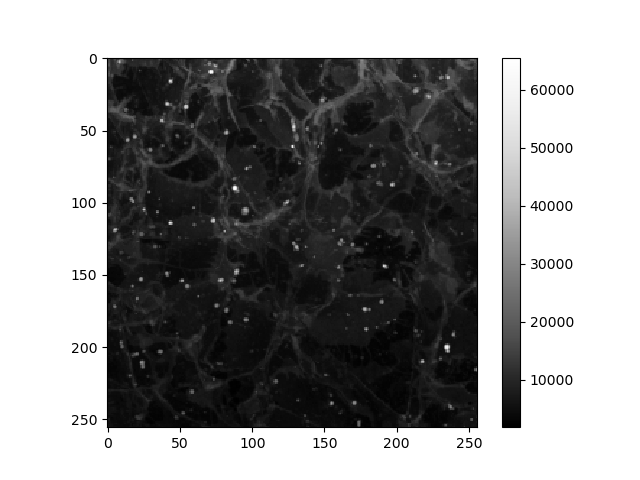
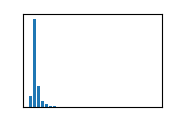

In [2]:
image = cells3d()[:,0,...]
cle.asarray(image)

In [3]:
def level_set_gpu():
    result_gpu = cle.morphological_snakes(image, n_iter=50, smoothing=0)

def level_set_cpu():
    result_cpu = morphological_chan_vese(image, iterations=50, smoothing=0)

In [4]:
#time_in_s = timeit.timeit(level_set_gpu, number=10)
#print("GPU time = ", time_in_s)

In [5]:
#time_in_s = timeit.timeit(level_set_cpu, number=10)
#print("CPU time = ", time_in_s)

In [6]:
image2d = cells3d()[30,0,...]

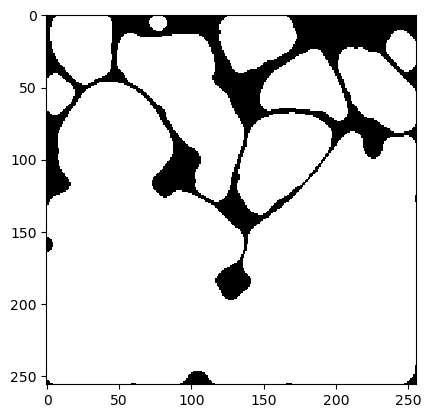

In [7]:
result_gpu = cle.morphological_snakes(image2d, n_iter=50, smoothing=10)
cle.imshow(result_gpu)

C:\Users\haase\AppData\Local\Temp\ipykernel_14056\1675731855.py:1: FutureWarning: `iterations` is a deprecated argument name for `morphological_chan_vese`. It will be removed in version 1.0. Please use `num_iter` instead.
  result_cpu = morphological_chan_vese(image2d, iterations=50, smoothing=10)


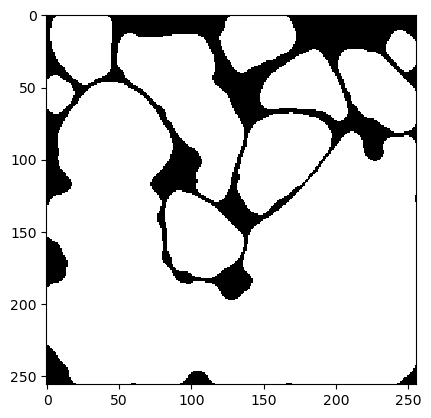

In [8]:
result_cpu = morphological_chan_vese(image2d, iterations=50, smoothing=10)
cle.imshow(result_cpu)